In [1]:
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import PIL
from IPython import display
import glob

%matplotlib inline

print(tf.__version__)
print(imageio.__version__)

2.6.0
2.9.0


## STEP 1. 작업환경 구성하기

In [6]:
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

SyntaxError: invalid syntax (634210369.py, line 1)

### STEP 2. 데이터셋 구성하기

- `cifar10 데이터 불러오기`

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

- `-1 ~ 1로 정규화`

In [3]:
train_x = (train_x-127.5)/127.5
test_x = (test_x-127.5)/127.5

- `정규화 확인`

In [4]:
print(train_x.min(), "/", train_x.max())
print(test_x.min(), "/", test_x.max())

-1.0 / 1.0
-1.0 / 1.0


- `시각화 하기`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


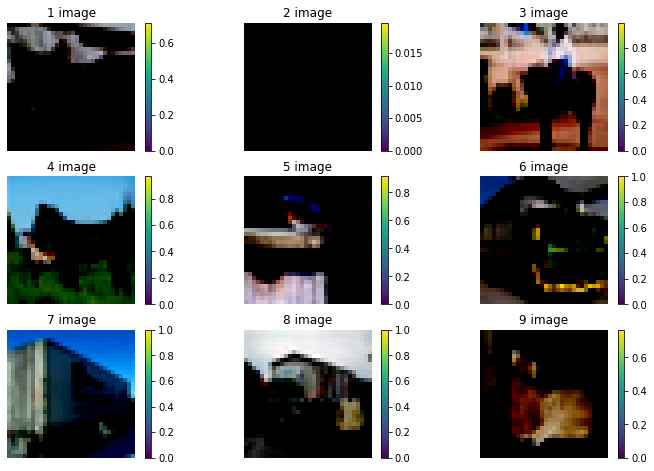

In [5]:
plt.figure(figsize=(12,8))
for idx, i in enumerate(train_x[9:18]) :
    plt.subplot(3,3,idx+1)
    plt.title(f'{idx+1} image')
    plt.imshow(i)
    plt.colorbar()
    plt.axis('off')
    
plt.show()

- `미니배치 데이터셋을 구성`

In [6]:
BUFFER_SIZE = train_x.shape[0] # 50,000
BATCH_SIZE = 256
BUFFER_SIZE, BATCH_SIZE

(50000, 256)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### STEP 3. 생성자 모델 구현하기

- `Generator 정의` : 7\*7\*256 → 8\*8\*256, 마지막 필터개수 1 → 3 으로 조정

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()

    # First: Dense layer
    ## 수정한 부분1
    model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization()) # 배치 정규화 사용
    model.add(tf.keras.layers.LeakyReLU()) # LeakyReLU 활성화 함수 사용

    # Second: Reshape layer
    ## 수정한 부분1
    model.add(tf.keras.layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=5, use_bias=False, strides=1, padding='same'))
    model.add(tf.keras.layers.BatchNormalization()) # 배치 정규화 사용
    model.add(tf.keras.layers.LeakyReLU()) # LeakyReLU 활성화 함수 사용

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=5, use_bias=False, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization()) # 배치 정규화 사용
    model.add(tf.keras.layers.LeakyReLU()) # LeakyReLU 활성화 함수 사용

    # Fifth: Conv2DTranspose layer
    ## 수정한 부분2
    model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [9]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

- `시각화`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 31.5, 31.5, -0.5)

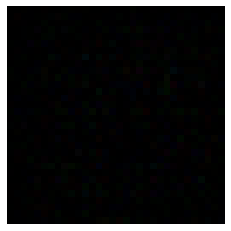

In [10]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0,:,:,:]) # 3채널에 맞게 수정
plt.axis('off')

- 이상하게도 검은화면 밖에 뜨지 않아, 각 채널별로 이상이 없는 지 시각화 해보았다.

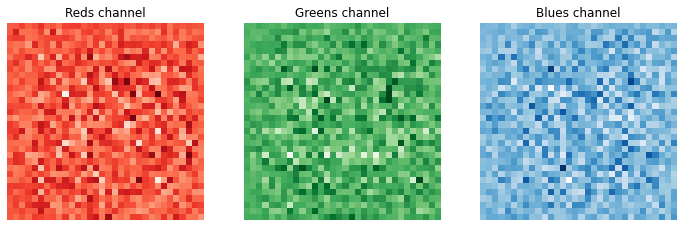

In [11]:
color = {0:'Reds', 1:'Greens', 2:'Blues'}
plt.figure(figsize=(12,8))

for idx in range(3) :
    plt.subplot(1,3,idx+1)
    plt.title(f"{color[idx]} channel")
    plt.imshow(generated_image[0, :, :, idx], cmap=color[idx])
    plt.axis('off')

plt.show()

- 생성된 데이터의 전체 및 채널별 최대값과 최소값을 알아보았다.

In [12]:
print(f'전체 : {np.array(generated_image).flatten().max()}, {np.array(generated_image).flatten().min()}')
print(f'Red : {np.array(generated_image[0,:,:,0]).flatten().max()}, {np.array(generated_image[0,:,:,0]).flatten().min()}')
print(f'Green : {np.array(generated_image[0,:,:,1]).flatten().max()}, {np.array(generated_image[0,:,:,1]).flatten().min()}')
print(f'Blue : {np.array(generated_image[0,:,:,2]).flatten().max()}, {np.array(generated_image[0,:,:,2]).flatten().min()}')

전체 : 0.0568355955183506, -0.06403781473636627
Red : 0.044874925166368484, -0.05644868314266205
Green : 0.04375719279050827, -0.06403781473636627
Blue : 0.0568355955183506, -0.04538951441645622


- 이에 따라 적당한 Scale을 한 후 다시 시각화를 해보고자 한다

- 첫번째 : AbsMinMax Scale
---

In [13]:
max_value = np.array(generated_image).flatten().max()
min_value = np.array(generated_image).flatten().min()

absmax = max(abs(max_value), abs(min_value))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


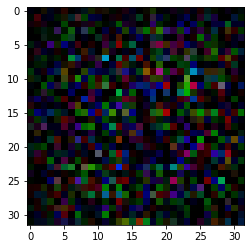

In [14]:
import matplotlib
plt.imshow(generated_image[0,:,:,:]/absmax)

- 그래도 어느정도 윤곽이 잡히는 그림체가 나온다.

.

- 두 번째 : Standard Scale
---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


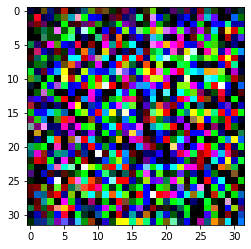

In [15]:
plt.imshow((generated_image[0,:,:,:]\
           - np.array(generated_image[0,:,:,:]).mean())\
           /np.array(generated_image[0,:,:,:]).std())

- 결과적으로 데이터의 폭이 작아서 그렇지, 무작위한 그림의 형태가 완성되는 것을 확인할 수 있었다.

### STEP 4. 판별자 모델 구현하기

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.LeakyReLU()) # LeakyReLU 활성화 함수 사용
    model.add(tf.keras.layers.Dropout(0.3)) # Dropout은 0.3을 사용

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU()) # LeakyReLU 활성화 함수 사용
    model.add(tf.keras.layers.Dropout(0.3)) # Dropout은 0.3을 사용

    # Third: Flatten Layer
    model.add(tf.keras.layers.Flatten())

    # Fourth: Dense Layer
    model.add(tf.keras.layers.Dense(1))

    return model

In [17]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.003019]], dtype=float32)>

### STEP 5. 손실함수와 최적화 함수 구현하기

- `손실함수 구현`

- Cross Entropy : 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산
- Real Image 라벨 : 1 / Fake Image 라벨 : 0로 가정 시
    - 생성자의 학습 목표 : Fake Image에 대해 판별값이 1에 가까워지는 것
    - 판별자의 학습 목표 : Real Image 판별값이 1, Fake Image 판별값이 0에 가까워지는 것

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss # real_loss와 fake_loss를 더한 값
    return total_loss

- `정확도 구현`

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- `최적화 함수 선택` : Adam(learning rate는 `0.0001`)

In [23]:
0.0001==1e-4

True

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### STEP 6. 훈련과정 상세 기능 구현하기

- `1개 미니배치의 훈련 과정 구현` : train_step

In [32]:
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy   #(10) 리턴값

- `생성 데이터 저장` : generate_and_save_images

In [33]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    plt.show()

- `history 시각화` : draw_train_history

In [34]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 18    # matlab 차트의 기본 크기를 15,18으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

- `특정 epoch마다 모델을 저장` : checkpoint

In [35]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- ✨`훈련 구현` : train

In [40]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)
        
    return history

### STEP 7. 학습 과정 진행하기

In [41]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

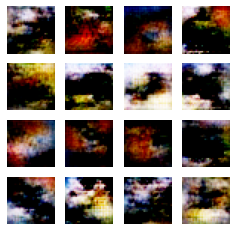

Time for training : 1805 sec


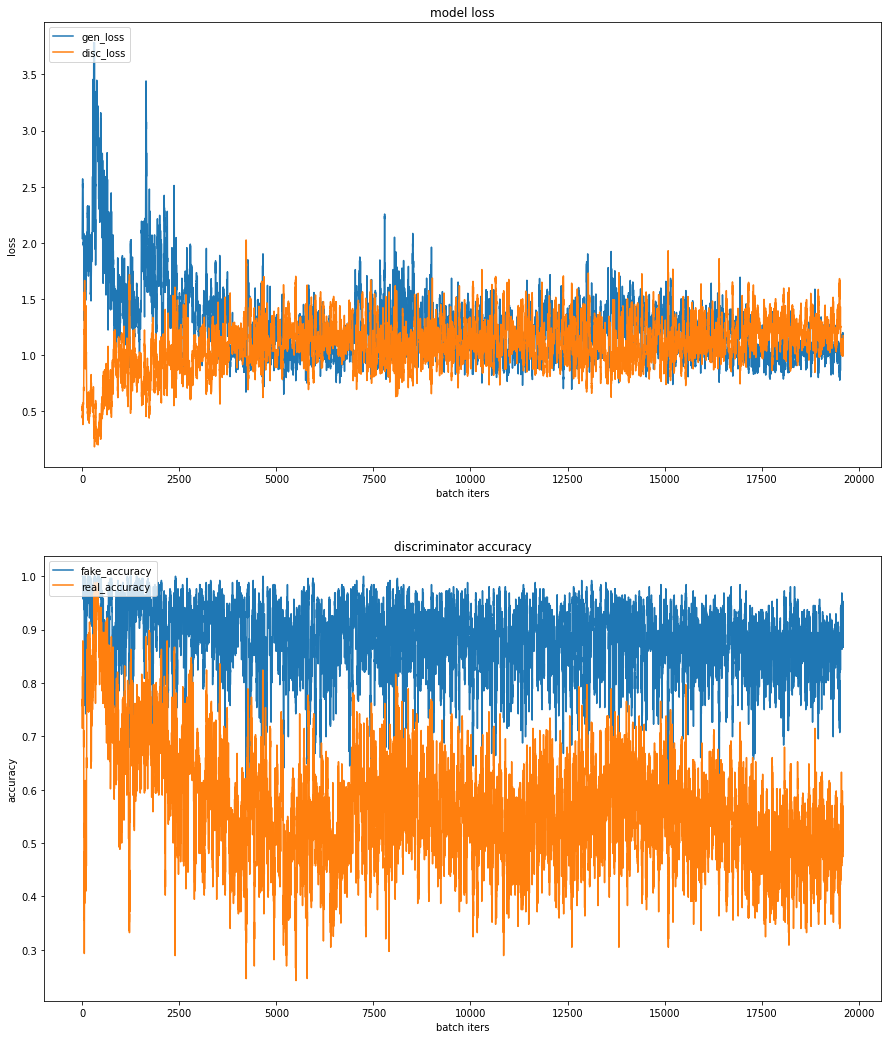

CPU times: user 30min 36s, sys: 2min 48s, total: 33min 24s
Wall time: 30min 7s


In [42]:
%%time
history = train(train_dataset, EPOCHS, save_every)

- `학습과정 시각화`

In [47]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

![이미지](https://github.com/NeatyNut/AIFFEL_Online_Quest/blob/main/DL3/Image/cifar10_dcgan.gif?raw=true)

![img](https://github.com/NeatyNut/AIFFEL_Online_Quest/blob/main/DL3/Image/train_history_0099.png?raw=true)

- 잘 형상화 되지 못한 모습이다.
- fake accuracy가 어느 범주에서부터 내려가지 않았다.

---

### STEP 8. (optional) GAN 훈련 과정 개선하기

- `20번 모델 선택`

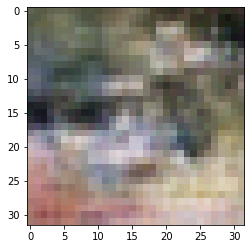

In [67]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/ckpt-20.data-00000-of-00001'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

plt.figure(figsize=(4,4))
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


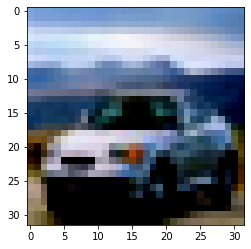

In [61]:
plt.figure(figsize=(4,4))
plt.imshow(train_x[-2])

- 상대적으로 애매한 이미지가 형성된다.

### 주요 성능 개선 방식
---
- 참고링크 : [https://github.com/soumith/ganhacks](https://github.com/soumith/ganhacks)
- 1. Normalize the inputs : normalize the images between -1 and 1 ☑️
- 2. A modified loss function : Flip labels when training generator: real = fake, fake = real ☑️
- 3. Use a spherical Z : Sample from a gaussian distribution ☑️
- 4. BatchNorm : Construct different mini-batches for real and fake ☑️
- 5. Avoid Sparse Gradients: ReLU, MaxPool ☑️
- 6. Use Soft and Noisy Labels : if it is real, then replace the label with a random number between 0.7 and 1.2, and if it is a fake sample, replace it with 0.0 and 0.3
- 7. DCGAN / Hybrid Models ☑️
- 8. Use stability tricks from RL : All stability tricks that work for deep deterministic policy gradients
- 9. Use the ADAM Optimizer ☑️
- 10. Track failures early ☑️, 분산 큰 상태로 loss 미감소
- 11. Dont balance loss via statistics (unless you have a good reason to) ☑️
- 12. If you have labels, use them
- 13. Add noise to inputs, decay over time
- 14. [notsure] Train discriminator more (sometimes)
- 15. [notsure] Batch Discrimination
- 16. Discrete variables in Conditional GANs : Use an Embedding layer, Add as additional channels to images
- 17. Use Dropouts in G in both train and test phase : Provide noise in the form of dropout (50%).

---
- `추가 적용 사항`
    - 13. 가우시안 노이즈 포함
    - 15. 배치 정규화
    - 17. 드롭아웃을 30% -> 50%로 조정

- `모델 재구성`

In [88]:
def make_generator_model2():
    model = tf.keras.Sequential()

    # First: Dense layer
    ## 수정한 부분1
    model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization()) # 배치 정규화 사용
    model.add(tf.keras.layers.LeakyReLU()) # LeakyReLU 활성화 함수 사용
    model.add(tf.keras.layers.Dropout(0.5))
    
    # Second: Reshape layer
    ## 수정한 부분1
    model.add(tf.keras.layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=5, use_bias=False, strides=1, padding='same'))
    model.add(tf.keras.layers.BatchNormalization()) # 배치 정규화 사용
    model.add(tf.keras.layers.LeakyReLU()) # LeakyReLU 활성화 함수 사용
    model.add(tf.keras.layers.Dropout(0.5))
    
    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=5, use_bias=False, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization()) # 배치 정규화 사용
    model.add(tf.keras.layers.LeakyReLU()) # LeakyReLU 활성화 함수 사용
    model.add(tf.keras.layers.Dropout(0.5))
    
    # Fifth: Conv2DTranspose layer
    ## 수정한 부분2
    model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [89]:
def make_discriminator_model2():
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(tf.keras.layers.GaussianNoise(stddev=0.1, input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU()) # LeakyReLU 활성화 함수 사용
    model.add(tf.keras.layers.Dropout(0.5)) # Dropout은 0.5를 사용

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU()) # LeakyReLU 활성화 함수 사용
    model.add(tf.keras.layers.Dropout(0.5)) # Dropout은 0.5를 사용

    # Third: Flatten Layer
    model.add(tf.keras.layers.Flatten())

    # Fourth: Dense Layer
    model.add(tf.keras.layers.Dense(1))

    return model

In [90]:
generator2 = make_generator_model2()
generator2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 128)        

In [91]:
discriminator2 = make_discriminator_model2()
discriminator2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 128)        

In [98]:
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step2(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator2(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator2(images, training=True)
        fake_output = discriminator2(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator2.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator2.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator2.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator2.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy   #(10) 리턴값

In [99]:
def train2(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step2(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator2, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator2, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)
        
    return history

- `학습`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

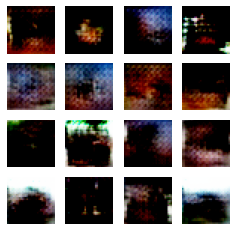

Time for training : 1941 sec


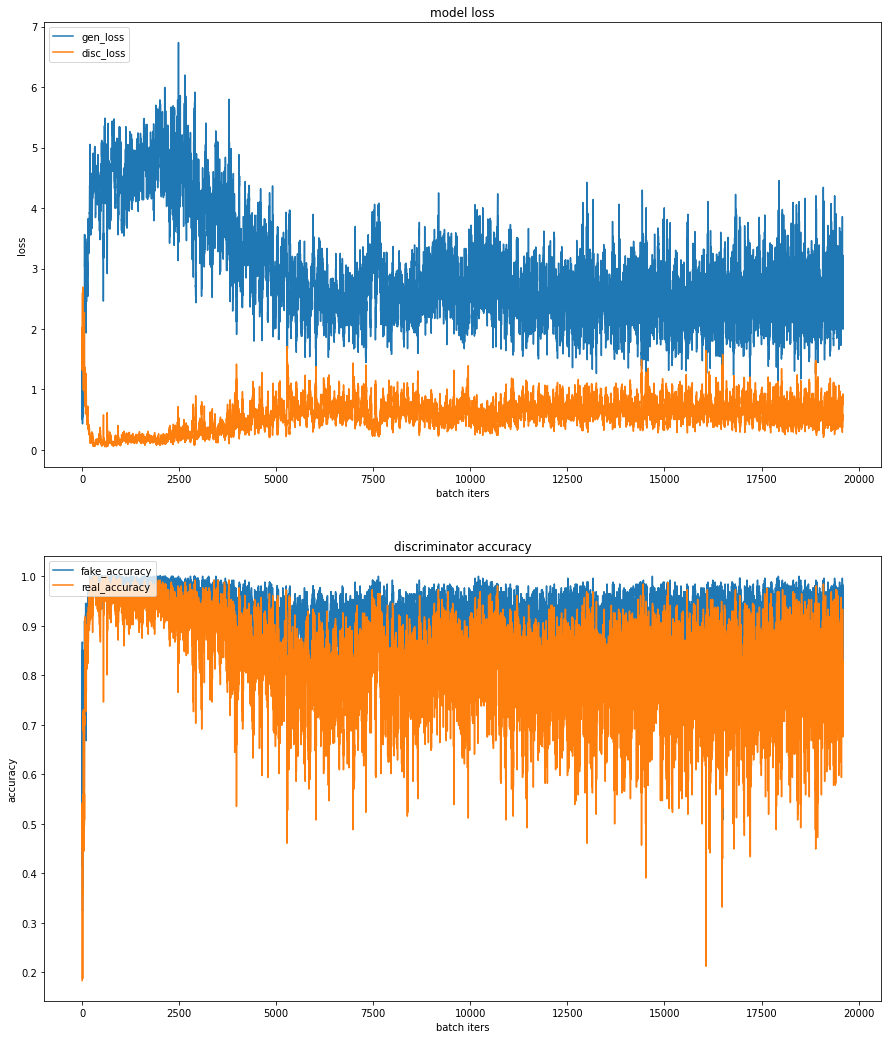

CPU times: user 32min 38s, sys: 2min 45s, total: 35min 24s
Wall time: 32min 23s


In [100]:
%%time
history = train2(train_dataset, EPOCHS, save_every)

In [154]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

- `생성된 개구리 같은 사진`

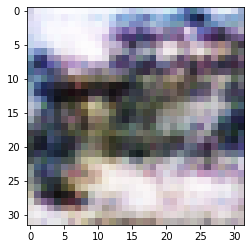

In [129]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/ckpt-20.data-00000-of-00001'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator2 = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator2(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

plt.figure(figsize=(4,4))
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

---

- `실제 개구리 사진`

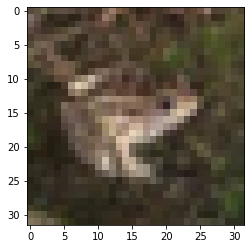

In [206]:
plt.figure(figsize=(4,4))
img = (train_x[22]*127.5 + 127.5).astype(int)
plt.imshow(img)

- 그래도 개구리 같은 느낌이 드는 사진을 얻을 수 있었다.

![이미지](https://github.com/NeatyNut/AIFFEL_Online_Quest/blob/main/DL3/Image/cifar10_dcgan2.gif?raw=true)

![img](https://github.com/NeatyNut/AIFFEL_Online_Quest/blob/main/DL3/Image/train_history2_0099.png?raw=true)

### 회고
#### Keep
- 채널에 대한 이해를 바탕으로 코드 수정을 진행하였다.
- 나름의 이해를 위해 채널별로 시각화를 해보는 등, 전 과정을 이해하려 노력하였다.

#### Problem
- 시간에 대한 고려가 부족했다. 남은 시간이 부족하여 step 8번 관련 논문을 읽어보지 못하고, 학습률 조정도 못한 채, 정규 시간을 끝냈다.

#### Try
- 따로 시간을 내어 설명되었던 몇몇 요소들을 나름대로 추가해보아 모델 개선을 시도해보았다. 아까보단 조금 더 그림 같은 것이 나왔다고 생각한다. 시간이 더 있었다면 generator에 대한 제약을 일부 줄이거나 서로 차등한 학습률을 부여하여 조정하였을 것 같다.